In [26]:
import sys
if "/kaggle/input/speakerreclab3" not in sys.path:
    sys.path.append("/kaggle/input/speakerreclab3")

if "/kaggle/input/models-huan" not in sys.path:
    sys.path.append("/kaggle/input/models-huan")

In [27]:
# Import of modules
import os
import random
import math
import numpy

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader

from DatasetLoader import loadWAV, AugmentWAV
from dataprep import download_dataset, concatenate, extract_dataset, part_extract, download_protocol, split_musan
from ResNetBlocks import *
from LossFunction import SoftmaxLoss, AMSoftmaxLoss, AAMSoftmaxLoss
from Optimizer import SGDOptimizer, AdamOptimizer
from Scheduler import OneCycleLRScheduler, StepLRScheduler
from load_save_pth import saveParameters, loadParameters
from preproc import PreEmphasis

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
class train_dataset_loader(Dataset):
    # Train dataset loader
    
    def __init__(self, train_list, max_frames, train_path, augment=False, musan_path=None, rir_path=None):
        self.max_frames  = max_frames
        self.augment     = augment
        if self.augment:
            self.augment_wav = AugmentWAV(musan_path=musan_path, rir_path=rir_path, max_frames=max_frames)
        # Make a dictionary of ID names and ID indices
        dictkeys = list(set([x.split()[0] for x in train_list]))
        dictkeys.sort()
        dictkeys = {key: ii for ii, key in enumerate(dictkeys)}
        # Parse the training list into file names and ID indices
        self.data_list  = []
        self.data_label = []
        for lidx, line in enumerate(train_list):
            data = line.strip().split()
            speaker_label = dictkeys[data[0]]
            filename = os.path.join(train_path, data[1])
            self.data_label.append(speaker_label)
            self.data_list.append(filename)

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        audio = loadWAV(self.data_list[index], self.max_frames, evalmode=False)
        if self.augment:
            ###########################################################
            # Here is your code
            prob1 = numpy.random.random_sample()
            prob2 = numpy.random.random_sample()
            if prob1 <= 0.50:
                if prob2 <= 0.25:
                    audio = self.augment_wav.additive_noise(self.augment_wav.noisetypes[0], audio)
                elif prob2 <= 0.50:
                    audio = self.augment_wav.additive_noise(self.augment_wav.noisetypes[1], audio)
                elif prob2 <= 0.75:
                    audio = self.augment_wav.additive_noise(self.augment_wav.noisetypes[2], audio)
                else:
                    audio = self.augment_wav.reverberate(audio)
            else:
                pass
            ###########################################################
        return torch.FloatTensor(audio), self.data_label[index]


class test_dataset_loader(Dataset):
    # Test dataset loader
    
    def __init__(self, test_list, max_frames, test_path):
        self.max_frames  = max_frames
        # Make a dictionary of ID names and ID indices
        dictkeys = list(set([x.split()[0] for x in test_list]))
        dictkeys.sort()
        dictkeys = {key: ii for ii, key in enumerate(dictkeys)}
        # Parse the training list into file names and ID indices
        self.data_list  = []
        self.data_label = []
        for lidx, line in enumerate(test_list):
            data = line.strip().split()
            speaker_label = dictkeys[data[0]]
            filename = os.path.join(test_path, data[1])
            self.data_label.append(speaker_label)
            self.data_list.append(filename)

    def __getitem__(self, index):
        audio = loadWAV(self.data_list[index], self.max_frames, evalmode=True, num_eval=1)
        return torch.FloatTensor(audio), self.data_label[index]

    def __len__(self):
        return len(self.data_list)

    
class MaxoutLinear(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MaxoutLinear, self).__init__()
        self.linear1 = nn.Linear(*args, **kwargs)
        self.linear2 = nn.Linear(*args, **kwargs)

    def forward(self, x):
        return torch.max(self.linear1(x), self.linear2(x))

    
class ResNet(nn.Module):
    # ResNet model for speaker recognition

    def __init__(self, block, layers, activation, num_filters, nOut, encoder_type='SP', n_mels=64, log_input=True, **kwargs):
        super(ResNet, self).__init__()
        print('Embedding size is %d, encoder %s.'%(nOut, encoder_type))
        self.inplanes     = num_filters[0]
        self.encoder_type = encoder_type
        self.n_mels       = n_mels
        self.log_input    = log_input
        self.torchfb      = torch.nn.Sequential(PreEmphasis(), 
                                                  torchaudio.transforms.MelSpectrogram(sample_rate=16000, 
                                                                                       n_fft=512, 
                                                                                       win_length=400, 
                                                                                       hop_length=160, 
                                                                                       window_fn=torch.hamming_window, 
                                                                                       n_mels=n_mels))
        self.instancenorm   = nn.InstanceNorm1d(n_mels)
        self.conv1  = nn.Conv2d(1, num_filters[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1    = nn.BatchNorm2d(num_filters[0])
        self.relu   = activation(inplace=True)
#         self.relu   = activation()
        self.layer1 = self._make_layer(block, num_filters[0], layers[0], stride=1, activation=activation)
        self.layer2 = self._make_layer(block, num_filters[1], layers[1], stride=2, activation=activation)
        self.layer3 = self._make_layer(block, num_filters[2], layers[2], stride=2, activation=activation)
        self.layer4 = self._make_layer(block, num_filters[3], layers[3], stride=2, activation=activation)
        outmap_size = int(self.n_mels/8)
        self.attention = nn.Sequential(nn.Conv1d(num_filters[3]*outmap_size, 128, kernel_size=1), 
                                       nn.ReLU(), 
                                       nn.BatchNorm1d(128), 
                                       nn.Conv1d(128, num_filters[3]*outmap_size, kernel_size=1), 
                                       nn.Softmax(dim=2))
        if self.encoder_type == "SP":
            out_dim = num_filters[3]*outmap_size*2
        elif self.encoder_type == "ASP":
            out_dim = num_filters[3]*outmap_size*2
        else:
            raise ValueError('Undefined encoder')
        self.fc = nn.Sequential(MaxoutLinear(out_dim, nOut), nn.BatchNorm1d(nOut, affine=False))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, activation=nn.ReLU):
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes*block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, activation=activation))
        self.inplanes = planes*block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, activation=activation))
        return nn.Sequential(*layers)

    def new_parameter(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out

    def forward(self, x):
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=False):
                x = self.torchfb(x) + 1e-6
                if self.log_input: x = x.log()
                x = self.instancenorm(x).unsqueeze(1)


        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.encoder_type == "ASP":
            x = x.reshape(x.shape[0], -1, x.shape[3])
            att_weights = self.attention(x)
            el_mat_prod = torch.mul(x, att_weights)
            mean = torch.mean(el_mat_prod, 2)
            variance = torch.std(el_mat_prod, 2)
            stat_pooling = torch.cat((mean,variance), 1)
        if self.encoder_type == "SP":
            mean = torch.mean(x, 3)
            std = torch.std(x, 3)
            stat_pooling = torch.cat((mean, std), 2).reshape(x.shape[0], -1)
        x = self.fc(stat_pooling)

        return x
    
    
class MainModel(nn.Module):
    def __init__(self, model, trainfunc, **kwargs):
        super(MainModel, self).__init__()
        self.__S__ = model
        self.__L__ = trainfunc

    def forward(self, data, label=None):
        data = data.reshape(-1, data.size()[-1]).to(device)
        outp = self.__S__.forward(data)
        if label == None: 
            return outp
        else:
            outp = outp.reshape(1, -1, outp.size()[-1]).transpose(1, 0).squeeze(1)
            nloss, prec1 = self.__L__.forward(outp, label)
            return nloss, prec1
        
        
def train_network(train_loader, main_model, optimizer, scheduler, num_epoch, verbose=False):
    # Function to train model
    assert scheduler[1] in ['epoch', 'iteration']
    main_model.train()
    stepsize = train_loader.batch_size
    loss    = 0
    top1    = 0
    counter = 0
#     index   = 0
    for data, data_label in train_loader:
        data = data.transpose(1, 0)
        ###########################################################
        # Here is your code
        main_model.zero_grad()
        data_label = torch.LongTensor(data_label).to(device)
        nloss, prec1 = main_model(data, data_label)
        nloss.backward()
        optimizer.step()
        loss    += nloss.detach().cpu().item()
        top1    += prec1.detach().cpu().item()
        counter += 1
#         index   += stepsize
        optimizer.zero_grad()
        ###########################################################
        if verbose:
            print("Epoch {:1.0f}, Batch {:1.0f}, LR {:f} Loss {:f}, Accuracy {:2.3f}%".format(num_epoch, counter, optimizer.param_groups[0]['lr'], loss/counter, top1/counter))
        if scheduler[1] == 'iteration': scheduler[0].step()
    if scheduler[1] == 'epoch': scheduler[0].step()
    return (loss/counter, top1/counter)


def test_network(test_loader, main_model):
    # Function to test model
    main_model.eval()
    loss    = 0
    top1    = 0
    counter = 0
    for data, data_label in test_loader:
        data = data.transpose(1, 0)
        ###########################################################
        # Here is your code
        label = torch.LongTensor(data_label).to(device)
        with torch.no_grad():
            nloss, prec1 = main_model(data, label)
        loss    += nloss.detach().cpu().item()
        top1    += prec1.detach().cpu().item()
        counter += 1
        ###########################################################
    return (loss/counter, top1/counter)

In [30]:
# Select hyperparameters

# Acoustic features
n_mels            = 40                                   # number of mel filters in bank filters
log_input         = True                                 # logarithm of features by level

# Neural network archtecture
layers            = [3, 4, 6, 3]                         # number of ResNet blocks in different level of frame level
activation        = nn.ReLU                              # activation function used in ResNet blocks
num_filters       = [32, 64, 128, 256]                   # number of filters of ResNet blocks in different level of frame level
encoder_type      = 'SP'                                 # type of statistic pooling layer ('SP'  – classical statistic pooling 
                                                         # layer and 'ASP' – attentive statistic pooling)
nOut              = 512                                  # embedding size

# Loss function for angular losses
margin            = 0.35                                 # margin parameter
scale             = 32.0                                 # scale parameter

# Train dataloader
max_frames_train  = 200                                  # number of frame to train
train_path        = '../input/speakerreclab3/vox1_dev_wav/wav'          # path to train wav files
batch_size_train  = 384                               # batch size to train
pin_memory        = False                                # pin memory
num_workers_train = 2                                    # number of workers to train
shuffle           = True                                 # shuffling of training examples

# Validation dataloader
max_frames_val    = 1000                                 # number of frame to validate
val_path          = '../input/speakerreclab3/vox1_dev_wav/wav'          # path to val wav files
batch_size_val    = 1                                  # batch size to validate
num_workers_val   = 2                                    # number of workers to validate

# Test dataloader
max_frames_test   = 1000                                 # number of frame to test
test_path         = '../input/speakerreclab3/vox1_dev_wav/wav'          # path to val wav files
batch_size_test   = 128                                  # batch size to test
num_workers_test  = 5                                    # number of workers to test

# Optimizer
lr                = 4                                  # learning rate value
weight_decay      = 0                               # weight decay value

# Scheduler
val_interval      = 1                                    # frequency of validation step
max_epoch         = 1                                   # number of epoches

# Augmentation
musan_path        = '../input/musansplit/musan_split'                # path to splitted SLR17 dataset
rir_path          = '../input/speakerreclab3/RIRS_NOISES_SIM/RIRS_NOISES/simulated_rirs' # path to SLR28 dataset

In [31]:
class train_dataset_loader(Dataset):
    # Train dataset loader
    
    def __init__(self, train_list, max_frames, train_path, augment=False, musan_path=None, rir_path=None):
        self.max_frames  = max_frames
        self.augment     = augment
        if self.augment:
            self.augment_wav = AugmentWAV(musan_path=musan_path, rir_path=rir_path, max_frames=max_frames)
        # Make a dictionary of ID names and ID indices
        dictkeys = list(set([x.split()[0] for x in train_list]))
        dictkeys.sort()
        dictkeys = {key: ii for ii, key in enumerate(dictkeys)}
        # Parse the training list into file names and ID indices
        self.data_list  = []
        self.data_label = []
        for lidx, line in enumerate(train_list):
            data = line.strip().split()
            speaker_label = dictkeys[data[0]]
            filename = os.path.join(train_path, data[1])
            self.data_label.append(speaker_label)
            self.data_list.append(filename)

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        audio = loadWAV(self.data_list[index], self.max_frames, evalmode=False)
        if self.augment:
            ###########################################################
            # Here is your code
            prob1 = numpy.random.random_sample()
            prob2 = numpy.random.random_sample()
            if prob1 <= 0.50:
                if prob2 <= 0.25:
                    audio = self.augment_wav.additive_noise(self.augment_wav.noisetypes[0], audio)
                elif prob2 <= 0.50:
                    audio = self.augment_wav.additive_noise(self.augment_wav.noisetypes[1], audio)
                elif prob2 <= 0.75:
                    audio = self.augment_wav.additive_noise(self.augment_wav.noisetypes[2], audio)
                else:
                    audio = self.augment_wav.reverberate(audio)
            else:
                pass
            ###########################################################
        return torch.FloatTensor(audio), self.data_label[index]


class test_dataset_loader(Dataset):
    # Test dataset loader
    
    def __init__(self, test_list, max_frames, test_path):
        self.max_frames  = max_frames
        # Make a dictionary of ID names and ID indices
        dictkeys = list(set([x.split()[0] for x in test_list]))
        dictkeys.sort()
        dictkeys = {key: ii for ii, key in enumerate(dictkeys)}
        # Parse the training list into file names and ID indices
        self.data_list  = []
        self.data_label = []
        for lidx, line in enumerate(test_list):
            data = line.strip().split()
            speaker_label = dictkeys[data[0]]
            filename = os.path.join(test_path, data[1])
            self.data_label.append(speaker_label)
            self.data_list.append(filename)

    def __getitem__(self, index):
        audio = loadWAV(self.data_list[index], self.max_frames, evalmode=True, num_eval=1)
        return torch.FloatTensor(audio), self.data_label[index]

    def __len__(self):
        return len(self.data_list)

    
class MaxoutLinear(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MaxoutLinear, self).__init__()
        self.linear1 = nn.Linear(*args, **kwargs)
        self.linear2 = nn.Linear(*args, **kwargs)

    def forward(self, x):
        return torch.max(self.linear1(x), self.linear2(x))

    
class ResNet(nn.Module):
    # ResNet model for speaker recognition

    def __init__(self, block, layers, activation, num_filters, nOut, encoder_type='SP', n_mels=64, log_input=True, **kwargs):
        super(ResNet, self).__init__()
        print('Embedding size is %d, encoder %s.'%(nOut, encoder_type))
        self.inplanes     = num_filters[0]
        self.encoder_type = encoder_type
        self.n_mels       = n_mels
        self.log_input    = log_input
        self.torchfb      = torch.nn.Sequential(PreEmphasis(), 
                                                  torchaudio.transforms.MelSpectrogram(sample_rate=16000, 
                                                                                       n_fft=512, 
                                                                                       win_length=400, 
                                                                                       hop_length=160, 
                                                                                       window_fn=torch.hamming_window, 
                                                                                       n_mels=n_mels))
        self.instancenorm   = nn.InstanceNorm1d(n_mels)
        self.conv1  = nn.Conv2d(1, num_filters[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1    = nn.BatchNorm2d(num_filters[0])
        self.relu   = activation(inplace=True)
#         self.relu   = activation()
        self.layer1 = self._make_layer(block, num_filters[0], layers[0], stride=1, activation=activation)
        self.layer2 = self._make_layer(block, num_filters[1], layers[1], stride=2, activation=activation)
        self.layer3 = self._make_layer(block, num_filters[2], layers[2], stride=2, activation=activation)
        self.layer4 = self._make_layer(block, num_filters[3], layers[3], stride=2, activation=activation)
        outmap_size = int(self.n_mels/8)
        self.attention = nn.Sequential(nn.Conv1d(num_filters[3]*outmap_size, 128, kernel_size=1), 
                                       nn.ReLU(), 
                                       nn.BatchNorm1d(128), 
                                       nn.Conv1d(128, num_filters[3]*outmap_size, kernel_size=1), 
                                       nn.Softmax(dim=2))
        if self.encoder_type == "SP":
            out_dim = num_filters[3]*outmap_size*2
        elif self.encoder_type == "ASP":
            out_dim = num_filters[3]*outmap_size*2
        else:
            raise ValueError('Undefined encoder')
        self.fc = nn.Sequential(MaxoutLinear(out_dim, nOut), nn.BatchNorm1d(nOut, affine=False))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, activation=nn.ReLU):
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes*block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, activation=activation))
        self.inplanes = planes*block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, activation=activation))
        return nn.Sequential(*layers)

    def new_parameter(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out

    def forward(self, x):
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=False):
                x = self.torchfb(x) + 1e-6
                if self.log_input: x = x.log()
                x = self.instancenorm(x).unsqueeze(1)


        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.encoder_type == "ASP":
            x = x.reshape(x.shape[0], -1, x.shape[3])
            att_weights = self.attention(x)
            el_mat_prod = torch.mul(x, att_weights)
            mean = torch.mean(el_mat_prod, 2)
            variance = torch.std(el_mat_prod, 2)
            stat_pooling = torch.cat((mean,variance), 1)
        if self.encoder_type == "SP":
            mean = torch.mean(x, 3)
            std = torch.std(x, 3)
            stat_pooling = torch.cat((mean, std), 2).reshape(x.shape[0], -1)
        x = self.fc(stat_pooling)

        return x
    
    
class MainModel(nn.Module):
    def __init__(self, model, trainfunc, **kwargs):
        super(MainModel, self).__init__()
        self.__S__ = model
        self.__L__ = trainfunc

    def forward(self, data, label=None):
        data = data.reshape(-1, data.size()[-1]).to(device)
        outp = self.__S__.forward(data)
        if label == None: 
            return outp
        else:
            outp = outp.reshape(1, -1, outp.size()[-1]).transpose(1, 0).squeeze(1)
            nloss, prec1 = self.__L__.forward(outp, label)
            return nloss, prec1
        
        
def train_network(train_loader, main_model, optimizer, scheduler, num_epoch, verbose=False):
    # Function to train model
    assert scheduler[1] in ['epoch', 'iteration']
    main_model.train()
    stepsize = train_loader.batch_size
    loss    = 0
    top1    = 0
    counter = 0
#     index   = 0
    for data, data_label in train_loader:
        data = data.transpose(1, 0)
        ###########################################################
        # Here is your code
        main_model.zero_grad()
        data_label = torch.LongTensor(data_label).to(device)
        nloss, prec1 = main_model(data, data_label)
        nloss.backward()
        optimizer.step()
        loss    += nloss.detach().cpu().item()
        top1    += prec1.detach().cpu().item()
        counter += 1
#         index   += stepsize
        optimizer.zero_grad()
        ###########################################################
        if verbose:
            print("Epoch {:1.0f}, Batch {:1.0f}, LR {:f} Loss {:f}, Accuracy {:2.3f}%".format(num_epoch, counter, optimizer.param_groups[0]['lr'], loss/counter, top1/counter))
        if scheduler[1] == 'iteration': scheduler[0].step()
    if scheduler[1] == 'epoch': scheduler[0].step()
    return (loss/counter, top1/counter)


def test_network(test_loader, main_model):
    # Function to test model
    main_model.eval()
    loss    = 0
    top1    = 0
    counter = 0
    for data, data_label in test_loader:
        data = data.transpose(1, 0)
        ###########################################################
        # Here is your code
        label = torch.LongTensor(data_label).to(device)
        with torch.no_grad():
            nloss, prec1 = main_model(data, label)
        loss    += nloss.detach().cpu().item()
        top1    += prec1.detach().cpu().item()
        counter += 1
        ###########################################################
    return (loss/counter, top1/counter)

# Generate data lists
train_list = []
val_list   = []
test_list  = []

with open('../input/speakerreclab3/iden_split.txt', 'r') as f:
    lines = f.readlines()
    
black_list = os.listdir('../input/speakerreclab3/vox1_test_wav/wav')   # exclude speaker IDs from VoxCeleb1 test set
num_train_spk = []                                      # number of train speakers

for line in lines:
    line   = line.strip().split(' ')
    spk_id = line[1].split('/')[0]
    
    if not (spk_id in black_list):
        num_train_spk.append(spk_id)
        
    else:
        continue
    
    # Train list
    if (line[0] == '1'):
        train_list.append(' '.join([spk_id, line[1]]))
    
    # Validation list
    elif (line[0] == '2'):
        val_list.append(' '.join([spk_id, line[1]]))
    
    # Test list
    elif (line[0] == '3'):
        test_list.append(' '.join([spk_id, line[1]]))
        
num_train_spk = len(set(num_train_spk))

# Initialize train dataloader (without augmentation)
train_dataset = train_dataset_loader(train_list=train_list, max_frames=max_frames_train, train_path=train_path)
train_loader  = DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=pin_memory, num_workers=num_workers_train, shuffle=shuffle)

# Initialize validation dataloader
val_dataset = test_dataset_loader(test_list=val_list, max_frames=max_frames_val, test_path=val_path)
val_loader  = DataLoader(val_dataset, batch_size=batch_size_val, num_workers=num_workers_val)

# Initialize model
model      = ResNet(BasicBlock, layers=layers, activation=activation, num_filters=num_filters, nOut=nOut, encoder_type=encoder_type, n_mels=n_mels, log_input=log_input)
trainfunc  = AAMSoftmaxLoss(nOut=nOut, nClasses=num_train_spk, margin=margin, scale=scale)
main_model = MainModel(model, trainfunc).to(device)

Embedding size is 512, encoder SP.
Initialised AAM softmax margin 0.350 scale 32.000.


In [32]:
# Generate data lists
train_list = []
val_list   = []
test_list  = []

with open('../input/speakerreclab3/iden_split.txt', 'r') as f:
    lines = f.readlines()
    
black_list = os.listdir('../input/speakerreclab3/vox1_test_wav/wav')   # exclude speaker IDs from VoxCeleb1 test set
num_train_spk = []                                      # number of train speakers

for line in lines:
    line   = line.strip().split(' ')
    spk_id = line[1].split('/')[0]
    
    if not (spk_id in black_list):
        num_train_spk.append(spk_id)
        
    else:
        continue
    
    # Train list
    if (line[0] == '1'):
        train_list.append(' '.join([spk_id, line[1]]))
    
    # Validation list
    elif (line[0] == '2'):
        val_list.append(' '.join([spk_id, line[1]]))
    
    # Test list
    elif (line[0] == '3'):
        test_list.append(' '.join([spk_id, line[1]]))
        
num_train_spk = len(set(num_train_spk))

In [33]:
# Initialize train dataloader (without augmentation)
train_dataset = train_dataset_loader(train_list=train_list, max_frames=max_frames_train, train_path=train_path)
train_loader  = DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=pin_memory, num_workers=num_workers_train, shuffle=shuffle)

# Initialize validation dataloader
val_dataset = test_dataset_loader(test_list=val_list, max_frames=max_frames_val, test_path=val_path)
val_loader  = DataLoader(val_dataset, batch_size=batch_size_val, num_workers=num_workers_val)

In [34]:
# Initialize model
model      = ResNet(BasicBlock, layers=layers, activation=activation, num_filters=num_filters, nOut=nOut, encoder_type=encoder_type, n_mels=n_mels, log_input=log_input)
trainfunc  = AAMSoftmaxLoss(nOut=nOut, nClasses=num_train_spk, margin=margin, scale=scale)
main_model = MainModel(model, trainfunc).to(device)

Embedding size is 512, encoder SP.
Initialised AAM softmax margin 0.350 scale 32.000.


In [35]:
# Initialize optimizer and scheduler
optimizer = SGDOptimizer(main_model.parameters(), lr=lr, weight_decay=weight_decay)
# optimizer = AdamOptimizer(main_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = OneCycleLRScheduler(optimizer, 
                                pct_start=0.30, 
                                cycle_momentum=False, 
                                max_lr=lr, 
                                div_factor=20, 
                                final_div_factor=10000, 
                                total_steps=max_epoch*len(train_loader))

Initialised SGD optimizer.
Initialised OneCycle LR scheduler.


In [37]:
if 0:
    start_epoch = 0
    checkpoint_flag = False

    if checkpoint_flag:
        start_epoch = loadParameters(main_model, optimizer, scheduler, path='../data/lab3_models/lab3_model_0004.pth')
        start_epoch = start_epoch + 1

    # Train model
    for num_epoch in range(start_epoch, max_epoch):
        train_loss, train_top1 = train_network(train_loader, main_model, optimizer, scheduler, num_epoch, verbose=True)

        print("Epoch {:1.0f}, Loss (train set) {:f}, Accuracy (train set) {:2.3f}%".format(num_epoch, train_loss, train_top1))

        if (num_epoch + 1)%val_interval == 0:
            _, val_top1 = test_network(val_loader, main_model)

            print("Epoch {:1.0f}, Accuracy (validation set) {:2.3f}%".format(num_epoch, val_top1))

            saveParameters(main_model, optimizer, scheduler, num_epoch, path='/kaggle/working')

In [ ]:
if 0:
    os.chdir(r'/kaggle/working')
    from IPython.display import FileLink
    FileLink(r'lab3_model_0019.pth')

# Implementing MFSE in basic

In [38]:
class train_dataset_loader(Dataset):
    # Train dataset loader
    
    def __init__(self, train_list, max_frames, train_path, augment=False, musan_path=None, rir_path=None):
        self.max_frames  = max_frames
        self.augment     = augment
        if self.augment:
            self.augment_wav = AugmentWAV(musan_path=musan_path, rir_path=rir_path, max_frames=max_frames)
        # Make a dictionary of ID names and ID indices
        dictkeys = list(set([x.split()[0] for x in train_list]))
        dictkeys.sort()
        dictkeys = {key: ii for ii, key in enumerate(dictkeys)}
        # Parse the training list into file names and ID indices
        self.data_list  = []
        self.data_label = []
        for lidx, line in enumerate(train_list):
            data = line.strip().split()
            speaker_label = dictkeys[data[0]]
            filename = os.path.join(train_path, data[1])
            self.data_label.append(speaker_label)
            self.data_list.append(filename)

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        audio = loadWAV(self.data_list[index], self.max_frames, evalmode=False)
        if self.augment:
            ###########################################################
            # Here is your code
            prob1 = numpy.random.random_sample()
            prob2 = numpy.random.random_sample()
            if prob1 <= 0.50:
                if prob2 <= 0.25:
                    audio = self.augment_wav.additive_noise(self.augment_wav.noisetypes[0], audio)
                elif prob2 <= 0.50:
                    audio = self.augment_wav.additive_noise(self.augment_wav.noisetypes[1], audio)
                elif prob2 <= 0.75:
                    audio = self.augment_wav.additive_noise(self.augment_wav.noisetypes[2], audio)
                else:
                    audio = self.augment_wav.reverberate(audio)
            else:
                pass
            ###########################################################
        return torch.FloatTensor(audio), self.data_label[index]


class test_dataset_loader(Dataset):
    # Test dataset loader
    
    def __init__(self, test_list, max_frames, test_path):
        self.max_frames  = max_frames
        # Make a dictionary of ID names and ID indices
        dictkeys = list(set([x.split()[0] for x in test_list]))
        dictkeys.sort()
        dictkeys = {key: ii for ii, key in enumerate(dictkeys)}
        # Parse the training list into file names and ID indices
        self.data_list  = []
        self.data_label = []
        for lidx, line in enumerate(test_list):
            data = line.strip().split()
            speaker_label = dictkeys[data[0]]
            filename = os.path.join(test_path, data[1])
            self.data_label.append(speaker_label)
            self.data_list.append(filename)

    def __getitem__(self, index):
        audio = loadWAV(self.data_list[index], self.max_frames, evalmode=True, num_eval=1)
        return torch.FloatTensor(audio), self.data_label[index]

    def __len__(self):
        return len(self.data_list)

    
class MaxoutLinear(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MaxoutLinear, self).__init__()
        self.linear1 = nn.Linear(*args, **kwargs)
        self.linear2 = nn.Linear(*args, **kwargs)

    def forward(self, x):
        return torch.max(self.linear1(x), self.linear2(x))
    
class MFIECA(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(MFIECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y

    
class ResNet(nn.Module):
    # ResNet model for speaker recognition

    def __init__(self, block, layers, activation, num_filters, nOut, encoder_type='SP', n_mels=64, log_input=True, **kwargs):
        super(ResNet, self).__init__()
        print('Embedding size is %d, encoder %s.'%(nOut, encoder_type))
        self.inplanes     = num_filters[0]
        self.encoder_type = encoder_type
        self.n_mels       = n_mels
        self.log_input    = log_input
        self.torchfb      = torch.nn.Sequential(PreEmphasis(), 
                                                  torchaudio.transforms.MelSpectrogram(sample_rate=16000, 
                                                                                       n_fft=512, 
                                                                                       win_length=400, 
                                                                                       hop_length=160, 
                                                                                       window_fn=torch.hamming_window, 
                                                                                       n_mels=n_mels))
        self.instancenorm   = nn.InstanceNorm1d(n_mels)
        self.conv1  = nn.Conv2d(1, num_filters[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1    = nn.BatchNorm2d(num_filters[0])
        self.relu   = activation(inplace=True)
#         self.relu   = activation()
        self.layer1 = self._make_layer(block, num_filters[0], layers[0], stride=1, activation=activation)
        self.layer2 = self._make_layer(block, num_filters[1], layers[1], stride=2, activation=activation)
        self.layer3 = self._make_layer(block, num_filters[2], layers[2], stride=2, activation=activation)
        self.layer4 = self._make_layer(block, num_filters[3], layers[3], stride=2, activation=activation)
        # Multi-Frequency Information Enhanced Channel Attention Modules
        self.mfieca1 = MFIECA(num_filters[0] * block.expansion)
        self.mfieca2 = MFIECA(num_filters[1] * block.expansion)
        self.mfieca3 = MFIECA(num_filters[2] * block.expansion)
        self.mfieca4 = MFIECA(num_filters[3] * block.expansion)

        outmap_size = int(self.n_mels/8)
        self.attention = nn.Sequential(nn.Conv1d(num_filters[3]*outmap_size, 128, kernel_size=1), 
                                       nn.ReLU(), 
                                       nn.BatchNorm1d(128), 
                                       nn.Conv1d(128, num_filters[3]*outmap_size, kernel_size=1), 
                                       nn.Softmax(dim=2))
        if self.encoder_type == "SP":
            out_dim = num_filters[3]*outmap_size*2
        elif self.encoder_type == "ASP":
            out_dim = num_filters[3]*outmap_size*2
        else:
            raise ValueError('Undefined encoder')
        self.fc = nn.Sequential(MaxoutLinear(out_dim, nOut), nn.BatchNorm1d(nOut, affine=False))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, activation=nn.ReLU):
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes*block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, activation=activation))
        self.inplanes = planes*block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, activation=activation))
        return nn.Sequential(*layers)

    def new_parameter(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out

    def forward(self, x):
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=False):
                x = self.torchfb(x) + 1e-6
                if self.log_input: x = x.log()
                x = self.instancenorm(x).unsqueeze(1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.mfieca1(x)

        x = self.layer2(x)
        x = self.mfieca2(x)

        x = self.layer3(x)
        x = self.mfieca3(x)

        x = self.layer4(x)
        x = self.mfieca4(x)

        if self.encoder_type == "ASP":
            x = x.reshape(x.shape[0], -1, x.shape[3])
            att_weights = self.attention(x)
            el_mat_prod = torch.mul(x, att_weights)
            mean = torch.mean(el_mat_prod, 2)
            variance = torch.std(el_mat_prod, 2)
            stat_pooling = torch.cat((mean, variance), 1)
        if self.encoder_type == "SP":
            mean = torch.mean(x, 3)
            std = torch.std(x, 3)
            stat_pooling = torch.cat((mean, std), 2).reshape(x.shape[0], -1)

        x = self.fc(stat_pooling)
        return x
    
    
class MainModel(nn.Module):
    def __init__(self, model, trainfunc, **kwargs):
        super(MainModel, self).__init__()
        self.__S__ = model
        self.__L__ = trainfunc

    def forward(self, data, label=None):
        data = data.reshape(-1, data.size()[-1]).to(device)
        outp = self.__S__.forward(data)
        if label == None: 
            return outp
        else:
            outp = outp.reshape(1, -1, outp.size()[-1]).transpose(1, 0).squeeze(1)
            nloss, prec1 = self.__L__.forward(outp, label)
            return nloss, prec1
        
        
def train_network(train_loader, main_model, optimizer, scheduler, num_epoch, verbose=False):
    # Function to train model
    assert scheduler[1] in ['epoch', 'iteration']
    main_model.train()
    stepsize = train_loader.batch_size
    loss    = 0
    top1    = 0
    counter = 0
#     index   = 0
    for data, data_label in train_loader:
        data = data.transpose(1, 0)
        ###########################################################
        # Here is your code
        main_model.zero_grad()
        data_label = torch.LongTensor(data_label).to(device)
        nloss, prec1 = main_model(data, data_label)
        nloss.backward()
        optimizer.step()
        loss    += nloss.detach().cpu().item()
        top1    += prec1.detach().cpu().item()
        counter += 1
#         index   += stepsize
        optimizer.zero_grad()
        ###########################################################
        if verbose:
            print("Epoch {:1.0f}, Batch {:1.0f}, LR {:f} Loss {:f}, Accuracy {:2.3f}%".format(num_epoch, counter, optimizer.param_groups[0]['lr'], loss/counter, top1/counter))
        if scheduler[1] == 'iteration': scheduler[0].step()
    if scheduler[1] == 'epoch': scheduler[0].step()
    return (loss/counter, top1/counter)


def test_network(test_loader, main_model):
    # Function to test model
    main_model.eval()
    loss    = 0
    top1    = 0
    counter = 0
    for data, data_label in test_loader:
        data = data.transpose(1, 0)
        ###########################################################
        # Here is your code
        label = torch.LongTensor(data_label).to(device)
        with torch.no_grad():
            nloss, prec1 = main_model(data, label)
        loss    += nloss.detach().cpu().item()
        top1    += prec1.detach().cpu().item()
        counter += 1
        ###########################################################
    return (loss/counter, top1/counter)

In [39]:
# Select hyperparameters

# Acoustic features
n_mels            = 40                                   # number of mel filters in bank filters
log_input         = True                                 # logarithm of features by level

# Neural network archtecture
layers            = [3, 4, 6, 3]                         # number of ResNet blocks in different level of frame level
activation        = nn.ReLU                              # activation function used in ResNet blocks
num_filters       = [32, 64, 128, 256]                   # number of filters of ResNet blocks in different level of frame level
encoder_type      = 'SP'                                 # type of statistic pooling layer ('SP'  – classical statistic pooling 
                                                         # layer and 'ASP' – attentive statistic pooling)
nOut              = 512                                  # embedding size

# Loss function for angular losses
margin            = 0.35                                 # margin parameter
scale             = 32.0                                 # scale parameter

# Train dataloader
max_frames_train  = 200                                  # number of frame to train
train_path        = '../input/speakerreclab3/vox1_dev_wav/wav'          # path to train wav files
batch_size_train  = 384                               # batch size to train
pin_memory        = False                                # pin memory
num_workers_train = 2                                    # number of workers to train
shuffle           = True                                 # shuffling of training examples

# Validation dataloader
max_frames_val    = 1000                                 # number of frame to validate
val_path          = '../input/speakerreclab3/vox1_dev_wav/wav'          # path to val wav files
batch_size_val    = 1                                  # batch size to validate
num_workers_val   = 2                                    # number of workers to validate

# Test dataloader
max_frames_test   = 1000                                 # number of frame to test
test_path         = '../input/speakerreclab3/vox1_dev_wav/wav'          # path to val wav files
batch_size_test   = 128                                  # batch size to test
num_workers_test  = 5                                    # number of workers to test

# Optimizer
lr                = 4                                  # learning rate value
weight_decay      = 0                               # weight decay value

# Scheduler
val_interval      = 1                                    # frequency of validation step
max_epoch         = 20                                 # number of epoches

# Augmentation
musan_path        = '../input/musansplit/musan_split'                # path to splitted SLR17 dataset
rir_path          = '../input/speakerreclab3/RIRS_NOISES_SIM/RIRS_NOISES/simulated_rirs' # path to SLR28 dataset

In [40]:
# Generate data lists
train_list = []
val_list   = []
test_list  = []

with open('../input/speakerreclab3/iden_split.txt', 'r') as f:
    lines = f.readlines()
    
black_list = os.listdir('../input/speakerreclab3/vox1_test_wav/wav')   # exclude speaker IDs from VoxCeleb1 test set
num_train_spk = []                                      # number of train speakers

for line in lines:
    line   = line.strip().split(' ')
    spk_id = line[1].split('/')[0]
    
    if not (spk_id in black_list):
        num_train_spk.append(spk_id)
        
    else:
        continue
    
    # Train list
    if (line[0] == '1'):
        train_list.append(' '.join([spk_id, line[1]]))
    
    # Validation list
    elif (line[0] == '2'):
        val_list.append(' '.join([spk_id, line[1]]))
    
    # Test list
    elif (line[0] == '3'):
        test_list.append(' '.join([spk_id, line[1]]))
        
num_train_spk = len(set(num_train_spk))

In [41]:
# Initialize train dataloader (without augmentation)
train_dataset = train_dataset_loader(train_list=train_list, max_frames=max_frames_train, train_path=train_path)
train_loader  = DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=pin_memory, num_workers=num_workers_train, shuffle=shuffle)

# Initialize validation dataloader
val_dataset = test_dataset_loader(test_list=val_list, max_frames=max_frames_val, test_path=val_path)
val_loader  = DataLoader(val_dataset, batch_size=batch_size_val, num_workers=num_workers_val)


In [42]:
# Initialize model
model      = ResNet(BasicBlock, layers=layers, activation=activation, num_filters=num_filters, nOut=nOut, encoder_type=encoder_type, n_mels=n_mels, log_input=log_input)
trainfunc  = AAMSoftmaxLoss(nOut=nOut, nClasses=num_train_spk, margin=margin, scale=scale)
main_model = MainModel(model, trainfunc).to(device)


Embedding size is 512, encoder SP.
Initialised AAM softmax margin 0.350 scale 32.000.


In [43]:

# Initialize optimizer and scheduler
optimizer = SGDOptimizer(main_model.parameters(), lr=lr, weight_decay=weight_decay)
# optimizer = AdamOptimizer(main_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = OneCycleLRScheduler(optimizer, 
                                pct_start=0.30, 
                                cycle_momentum=False, 
                                max_lr=lr, 
                                div_factor=20, 
                                final_div_factor=10000, 
                                total_steps=max_epoch*len(train_loader))

Initialised SGD optimizer.
Initialised OneCycle LR scheduler.


In [44]:
if 0:
    start_epoch = 0
    checkpoint_flag = False

    if checkpoint_flag:
        start_epoch = loadParameters(main_model, optimizer, scheduler, path='../data/lab3_models/lab3_model_0004.pth')
        start_epoch = start_epoch + 1

    # Train model
    for num_epoch in range(start_epoch, max_epoch):
        train_loss, train_top1 = train_network(train_loader, main_model, optimizer, scheduler, num_epoch, verbose=True)

        print("Epoch {:1.0f}, Loss (train set) {:f}, Accuracy (train set) {:2.3f}%".format(num_epoch, train_loss, train_top1))

        if (num_epoch + 1)%val_interval == 0:
            _, val_top1 = test_network(val_loader, main_model)

            print("Epoch {:1.0f}, Accuracy (validation set) {:2.3f}%".format(num_epoch, val_top1))

            saveParameters(main_model, optimizer, scheduler, num_epoch, path='/kaggle/working')

In [45]:
if 0:
    model_path = "model_miecam.pt"
    torch.save(model.state_dict(), model_path)


# Testing

In [46]:
# Initialize model
model_path_2 = "/kaggle/input/models-huan/model_miecam.pt"
model      = ResNet(BasicBlock, layers=layers, activation=activation, num_filters=num_filters, nOut=nOut, encoder_type=encoder_type, n_mels=n_mels, log_input=log_input)
trainfunc  = AAMSoftmaxLoss(nOut=nOut, nClasses=num_train_spk, margin=margin, scale=scale)
loaded_resnet_model = MainModel(model, trainfunc).to(device)

loaded_resnet_model.load_state_dict(torch.load(model_path_2, map_location=torch.device('cpu')))

# Move the model to the appropriate device (if using GPU)
loaded_resnet_model.to(device)

# Set the model to evaluation mode (important if your model has dropout or batch normalization layers)
loaded_resnet_model.eval()

Embedding size is 512, encoder SP.
Initialised AAM softmax margin 0.350 scale 32.000.


MainModel(
  (__S__): ResNet(
    (torchfb): Sequential(
      (0): PreEmphasis()
      (1): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
    )
    (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlo

In [47]:
def extract_features(model, test_loader):
    # Extract features for every waveform

    feats = {}

    for idx, data in enumerate(test_loader):
        inp1 = data[0][0].cuda()
        
        with torch.no_grad():
            ref_feat = model(inp1).detach().cpu()
        
        feats[data[1][0]] = ref_feat

    return feats

In [48]:
# Exercises in order to perform laboratory work


# Import of modules
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist, plot, show, grid, title, xlabel, ylabel, legend, axis, imshow


def tar_imp_hists(all_scores, all_labels):
    # Function to compute target and impostor histogram
    
    tar_scores = []
    imp_scores = []

    ###########################################################
    # Here is your code
    for idx, score in enumerate(all_scores):
        if all_labels[idx] == 0:
            imp_scores.append(score)
        elif all_labels[idx] == 1:
            tar_scores.append(score)
        else:
            raise Exception
    ###########################################################
    
    tar_scores = np.array(tar_scores)
    imp_scores = np.array(imp_scores)
    
    return tar_scores, imp_scores

def llr(all_scores, all_labels, tar_scores, imp_scores, gauss_pdf):
    # Function to compute log-likelihood ratio
    
    tar_scores_mean = np.mean(tar_scores)
    tar_scores_std  = np.std(tar_scores)
    imp_scores_mean = np.mean(imp_scores)
    imp_scores_std  = np.std(imp_scores)
    
    all_scores_sort   = np.zeros(len(all_scores))
    ground_truth_sort = np.zeros(len(all_scores), dtype='bool')
    
    ###########################################################
    # Here is your code
    scores_truth_tuples = zip(all_scores, all_labels)
    scores_truth_tuples_sort = sorted(scores_truth_tuples, key=lambda x: x[0])
    all_scores_sort = np.array([x[0] for x in scores_truth_tuples_sort])
    ground_truth_sort = np.array([x[1] for x in scores_truth_tuples_sort], dtype='bool')
    ###########################################################
    
    tar_gauss_pdf = np.zeros(len(all_scores))
    imp_gauss_pdf = np.zeros(len(all_scores))
    LLR           = np.zeros(len(all_scores))
    
    ###########################################################
    # Here is your code
    tar_gauss_pdf = gauss_pdf(all_scores_sort, tar_scores_mean, tar_scores_std)
    imp_gauss_pdf = gauss_pdf(all_scores_sort, imp_scores_mean, imp_scores_std)
    LLR = np.log(tar_gauss_pdf / imp_gauss_pdf)
    ###########################################################
    
    return ground_truth_sort, all_scores_sort, tar_gauss_pdf, imp_gauss_pdf, LLR

def map_test(ground_truth_sort, LLR, tar_scores, imp_scores, P_Htar):
    # Function to perform maximum a posteriori test
    
    len_thr = len(LLR)
    fnr_thr = np.zeros(len_thr)
    fpr_thr = np.zeros(len_thr)
    P_err   = np.zeros(len_thr)
    
    for idx in range(len_thr):
        solution = LLR > LLR[idx]                                      # decision
        
        err = (solution != ground_truth_sort)                          # error vector
        
        fnr_thr[idx] = np.sum(err[ ground_truth_sort])/len(tar_scores) # prob. of Type I  error P(Dimp|Htar), false negative rate (FNR)
        fpr_thr[idx] = np.sum(err[~ground_truth_sort])/len(imp_scores) # prob. of Type II error P(Dtar|Himp), false positive rate (FPR)
        
        P_err[idx]   = fnr_thr[idx]*P_Htar + fpr_thr[idx]*(1 - P_Htar) # prob. of error
    
    # Plot error's prob.
    plot(LLR, P_err, color='blue')
    xlabel('$LLR$'); ylabel('$P_e$'); title('Probability of error'); grid(); show()
        
    P_err_idx = np.argmin(P_err) # argmin of error's prob.
    P_err_min = fnr_thr[P_err_idx]*P_Htar + fpr_thr[P_err_idx]*(1 - P_Htar)
    
    return LLR[P_err_idx], fnr_thr[P_err_idx], fpr_thr[P_err_idx], P_err_min


def neyman_pearson_test(ground_truth_sort, LLR, tar_scores, imp_scores, fnr):
    # Function to perform Neyman-Pearson test
    
    thr   = 0.0
    fpr   = 0.0
    
    ###########################################################
    # Here is your code    
    len_thr = len(LLR)
    fnr_thr = np.zeros(len_thr)
    fpr_thr = np.zeros(len_thr)
    thr_fnr = np.zeros(len_thr)
    for idx in range(len_thr):
        solution = LLR > LLR[idx]
        thr_fnr[idx] = LLR[idx]
        err = (solution != ground_truth_sort)
        fnr_thr[idx] = np.sum(err[ ground_truth_sort])/len(tar_scores)
        fpr_thr[idx] = np.sum(err[~ground_truth_sort])/len(imp_scores)
    thr = thr_fnr[np.abs(fnr_thr-fnr).argmin()]
    idx_thr, = np.where(thr_fnr == thr)
    fpr = fpr_thr[idx_thr][0]
    ###########################################################
    
    return thr, fpr


def bayes_test(ground_truth_sort, LLR, tar_scores, imp_scores, P_Htar, C00, C10, C01, C11):
    # Function to perform Bayes' test
    
    thr   = 0.0
    fnr   = 0.0
    fpr   = 0.0
    AC    = 0.0
    
    ###########################################################
    # Here is your code
    len_thr = len(LLR)
    fnr_thr = np.zeros(len_thr)
    fpr_thr = np.zeros(len_thr)
    tnr_thr = np.zeros(len_thr)
    tpr_thr = np.zeros(len_thr)
    AC_eer   = np.zeros(len_thr)
    
    for idx in range(len_thr):
        solution = LLR > LLR[idx]
        err = (solution != ground_truth_sort)
        true = (solution == ground_truth_sort) 
        fnr_thr[idx] = np.sum(err[ ground_truth_sort])/len(tar_scores)
        fpr_thr[idx] = np.sum(err[~ground_truth_sort])/len(imp_scores)
        tnr_thr[idx] = np.sum(true[~ground_truth_sort])/len(tar_scores)
        tpr_thr[idx] = np.sum(true[ground_truth_sort])/len(imp_scores) 
        AC_eer[idx] = C00*tpr_thr[idx]*P_Htar + C10*fnr_thr[idx]*P_Htar + C01*fpr_thr[idx]*(1-P_Htar) + C11*tnr_thr[idx]*(1-P_Htar)
    
    AC_thr_idx = np.argmin(AC_eer) # argmin of error's prob.
    AC = AC_eer[AC_thr_idx]
    thr = LLR[AC_thr_idx]
    fnr = fnr_thr[AC_thr_idx]
    fpr = fpr_thr[AC_thr_idx]
    
    # Plot error's prob.
    plot(LLR, AC_eer, color='blue')
    xlabel('$LLR$'); ylabel('AC'); title('Probability of error'); grid(); show()
    ###########################################################
    
    return thr, fnr, fpr, AC


def minmax_test(ground_truth_sort, LLR, tar_scores, imp_scores, P_Htar_thr, C00, C10, C01, C11):
    # Function to perform minimax test
    
    thr    = 0.0
    fnr    = 0.0
    fpr    = 0.0
    AC     = 0.0
    P_Htar = 0.0

    ###########################################################
    # Here is your code
    len_thr = len(LLR)
    AC_array = np.zeros(len_thr)
    P_Htar_array = np.zeros(len_thr)
    fnr_array = np.zeros(len_thr)
    fpr_array = np.zeros(len_thr)
    thr_array = np.zeros(len_thr)
    AC = np.zeros((len_thr, len(P_Htar_thr)))
    
    for idx in range(len_thr):
        solution = LLR > LLR[idx]
        err = (solution != ground_truth_sort)
        true = (solution == ground_truth_sort) 
        fnr_thr = np.sum(err[ ground_truth_sort])/len(tar_scores)
        fpr_thr = np.sum(err[~ground_truth_sort])/len(imp_scores)
        tnr_thr = np.sum(true[~ground_truth_sort])/len(tar_scores)
        tpr_thr = np.sum(true[ground_truth_sort])/len(imp_scores) 
        for idy in range(len(P_Htar_thr)):
            AC[idx, idy] = C00*tpr_thr*P_Htar_thr[idy] + C10*fnr_thr*P_Htar_thr[idy] + C01*fpr_thr*(1 - P_Htar_thr[idy]) + C11*tnr_thr*(1 - P_Htar_thr[idy]) 
    max_phtar = np.max(AC, axis=1)
    idx_thr = np.argmin(max_phtar)
    AC_maxmin = max_phtar[idx_thr]
    thr = LLR[idx_thr]

    solution = LLR > thr
    err = (solution != ground_truth_sort)
    true = (solution == ground_truth_sort) 
    fnr = np.sum(err[ ground_truth_sort])/len(tar_scores)
    fpr = np.sum(err[~ground_truth_sort])/len(imp_scores)

    min_thr = np.min(AC, axis=0)
    idx_phtar = np.argmax(min_thr)
    AC_minmax = min_thr[idx_phtar]
    P_Htar = P_Htar_thr[idx_phtar]

#     imshow(AC[18705:18905, :], extent=[P_Htar_thr[0], P_Htar_thr[999], LLR[18905], LLR[18705]])
#     xlabel('$P(H_0)$'); ylabel('$LLR$'); title('Average cost surface (top view)'); show()
    return thr, fnr, fpr, AC_minmax, P_Htar, AC, idx_thr

In [49]:
class test_dataset_loader(Dataset):
    # Test dataset loader
    
    def __init__(self, test_list, test_path, eval_frames, num_eval, **kwargs):
        
        self.max_frames = eval_frames;
        self.num_eval   = num_eval
        self.test_path  = test_path
        self.test_list  = test_list

    def __getitem__(self, index):
        
        audio = loadWAV(os.path.join(self.test_path, self.test_list[index]), self.max_frames, evalmode=True, num_eval=self.num_eval)
        
        return torch.FloatTensor(audio), self.test_list[index]

    def __len__(self):
        
        return len(self.test_list)
# Load test protocol
with open('/kaggle/input/speakerreclab3/veri_test2.txt', 'r') as f:
    lines = f.readlines()
    
# Get a list of unique file names
files = list(itertools.chain(*[x.strip().split()[-2:] for x in lines]))
setfiles = list(set(files))
setfiles.sort()

# Define test data loader test_list=val_list, max_frames=max_frames_val, test_path=val_path
test_dataset = test_dataset_loader(setfiles, test_path='/kaggle/input/speakerreclab3/vox1_test_wav/wav/', eval_frames=200, num_eval=5)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, drop_last=False, sampler=None)

# Extract features for every imageя про
feats = extract_features(loaded_resnet_model, test_loader)
print("OK!")

OK!


In [50]:
# Compute scores between enroll and test speaker models
all_scores, all_labels, all_trials = compute_scores(feats, lines)

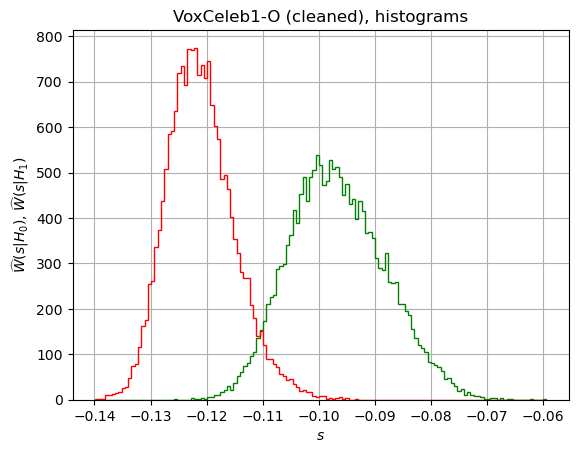

In [51]:
# Compute target and impostor histogram
tar_scores, imp_scores = tar_imp_hists(all_scores, all_labels)

# Plot histograms for target and impostor scores
min_scores = np.concatenate((tar_scores, imp_scores)).min()
max_scores = np.concatenate((tar_scores, imp_scores)).max()

hist(tar_scores, int(sqrt(len(tar_scores))), histtype='step', color='green', range=(min_scores, max_scores))
hist(imp_scores, int(sqrt(len(imp_scores))), histtype='step', color='red',   range=(min_scores, max_scores))
xlabel('$s$'); ylabel('$\widehat{W}(s|H_0)$, $\widehat{W}(s|H_1)$'); title('VoxCeleb1-O (cleaned), histograms'); grid(); show()

In [52]:
# Gaussian probability density function
gauss_pdf = lambda score, mu, sigma: 1/((abs(sigma) + 1e-10)*sqrt(2*pi))*np.exp(-(score - mu)**2/(2*(abs(sigma) + 1e-10)**2))

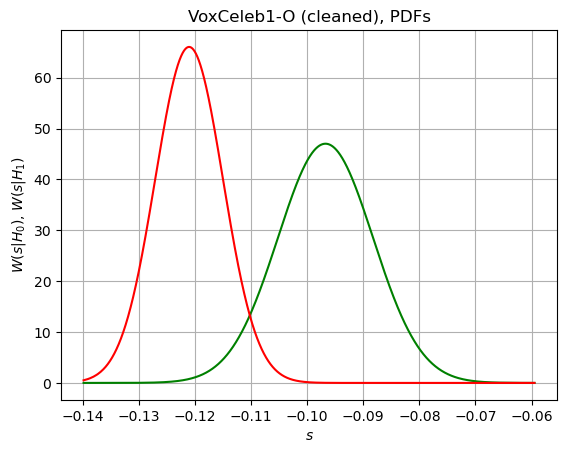

In [53]:
# Compute log-likelihood ratio
ground_truth_sort, all_scores_sort, tar_gauss_pdf, imp_gauss_pdf, LLR = llr(all_scores, all_labels, tar_scores, imp_scores, gauss_pdf)

# Plot PDFs for target and impostor scores
plot(all_scores_sort, tar_gauss_pdf, color='green')
plot(all_scores_sort, imp_gauss_pdf, color='red')
xlabel('$s$'); ylabel('$W(s|H_0)$, $W(s|H_1)$'); title('VoxCeleb1-O (cleaned), PDFs'); grid(); show()

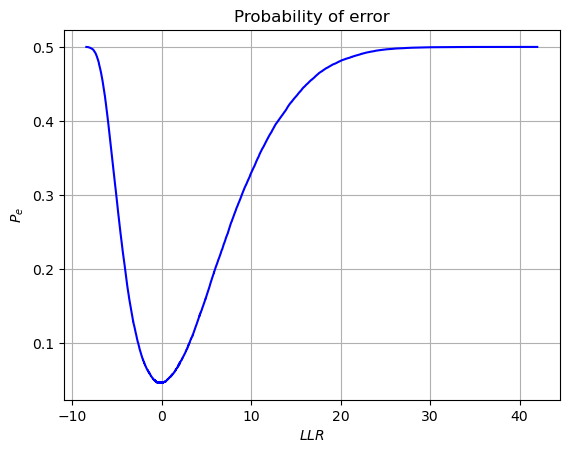

Threshold value:      -0.313
False negative rate:  0.036
False positive rate:  0.057
Probability of error: 0.046


In [54]:
# Maximum-likelihood test and maximum a posteriori (MAP) test. MAP is the same as Minimum Probability of Error Test
P_Htar = 1/2 # prob. of target hypothesis

llr_thr_val, fnr_thr_val, fpr_thr_val, P_err_min = map_test(ground_truth_sort, LLR, tar_scores, imp_scores, P_Htar)

print('Threshold value:      {0:.3f}'.format(llr_thr_val))
print('False negative rate:  {0:.3f}'.format(fnr_thr_val))
print('False positive rate:  {0:.3f}'.format(fpr_thr_val))
print('Probability of error: {0:.3f}'.format(P_err_min))

In [55]:
# Neyman-Pearson test
fnr    = 1/4 # given prob. of Type I error P(Dimp|Htar), false negative rate (FNR)

llr_thr_val, fpr_thr_val = neyman_pearson_test(ground_truth_sort, LLR, tar_scores, imp_scores, fnr)

print('Threshold value:      {0:.3f}'.format(llr_thr_val))
print('False negative rate:  {0:.3f}'.format(fnr))
print('False positive rate:  {0:.3f}'.format(fpr_thr_val))

Threshold value:      3.973
False negative rate:  0.250
False positive rate:  0.006


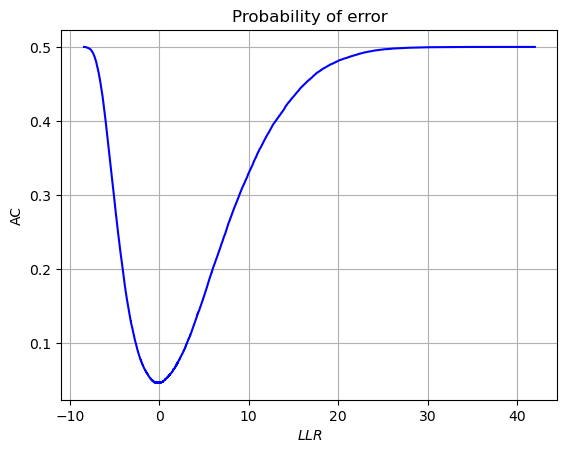

Threshold value:         -0.313
False negative rate:     0.036
False positive rate:     0.057
Minimum of average cost: 0.046


In [56]:
# Bayes' test
P_Htar = 1/2 # prob. of target hypothesis
C00    = 0   # cost of event (Dtar, Htar)
C10    = 1   # cost of event (Dimp, Htar)
C01    = 1   # cost of event (Dtar, Himp)
C11    = 0   # cost of event (Dimp, Himp)

llr_thr_val, fnr_thr_val, fpr_thr_val, AC_val = bayes_test(ground_truth_sort, LLR, tar_scores, imp_scores, P_Htar, C00, C10, C01, C11)

print('Threshold value:         {0:.3f}'.format(llr_thr_val))
print('False negative rate:     {0:.3f}'.format(fnr_thr_val))
print('False positive rate:     {0:.3f}'.format(fpr_thr_val))
print('Minimum of average cost: {0:.3f}'.format(AC_val))

In [57]:
# Minimax test
P_Htar_thr = np.linspace(0, 1, num=1000) # set of prob. of target hypothesis
C00        = 0                           # cost of event (Dtar, Htar)
C10        = 1                           # cost of event (Dimp, Htar)
C01        = 1                           # cost of event (Dtar, Himp)
C11        = 0                           # cost of event (Dimp, Himp)

llr_thr_val, fnr_thr_val, fpr_thr_val, AC_val, P_Htar_thr_val, AC, idx_thr = minmax_test(ground_truth_sort, LLR, tar_scores, imp_scores, P_Htar_thr, C00, C10, C01, C11)

print('Threshold value:        {0:.3f}'.format(llr_thr_val))
print('False negative rate:    {0:.3f}'.format(fnr_thr_val))
print('False positive rate:    {0:.3f}'.format(fpr_thr_val))
print('Minmax of average cost: {0:.3f}'.format(AC_val))
print('Probability of Htar:    {0:.3f}'.format(P_Htar_thr_val))

Threshold value:        0.054
False negative rate:    0.047
False positive rate:    0.047
Minmax of average cost: 0.047
Probability of Htar:    0.473


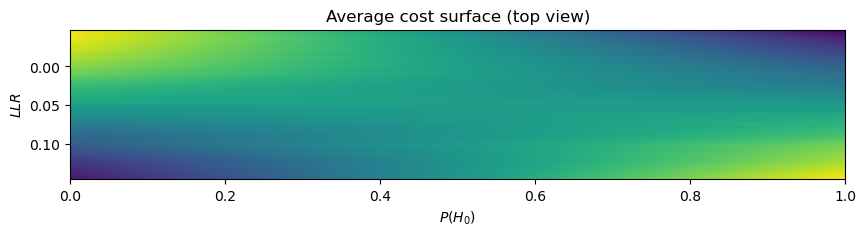

In [58]:
plt.figure(figsize=(10, 100))
imshow(AC[18705:18905, :], extent=[P_Htar_thr[0], P_Htar_thr[999], LLR[18905], LLR[18705]])
xlabel('$P(H_0)$'); ylabel('$LLR$'); title('Average cost surface (top view)'); show()

In [59]:
# Compute Equal Error Rate
EER, _ = get_eer(tar_scores, imp_scores)

print('Equal Error Rate (EER): {0:.3f}%'.format(EER))

Equal Error Rate (EER): 4.712%
